In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchtext
from torchtext.data import get_tokenizer
import spacy
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torchtext.vocab import vocab as build_vocab
from torch.utils.data import DataLoader, TensorDataset
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('courses.csv')
df.head()

,Course,ID,Department
0,Principles of Nutrition,BIOL,Biology
1,Nutrition for Fitness and Physical Activity,BIOL,Biology
2,Introduction to Human Physiology,BIOL,Biology
3,Biotechnology Management,BIOL,Biology
4,Living Biology at Brown and Beyond,BIOL,Biology


In [4]:
text = df['Course']
labels_text = df['Department']

In [5]:
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
tokens = [tokenizer(t) for t in text]
counter = Counter(word for seq in tokens for word in seq)
vocab = build_vocab(counter, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
print("Vocabulary size:", len(vocab))

Vocabulary size: 4489


In [6]:
sequences = [torch.tensor([vocab[token] for token in seq]) for seq in tokens]
padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=vocab["<unk>"])
print(padded_sequences.shape)

torch.Size([6690, 18])


In [7]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_text)
output_dim = len(label_encoder.classes_)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels_encoded, test_size=0.2, random_state=17)
train_data = TensorDataset(X_train, torch.tensor(y_train))
test_data = TensorDataset(X_test, torch.tensor(y_test))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [9]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

In [10]:
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for i, word in vocab.get_stoi().items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
torch_embeddings = torch.tensor(embedding_matrix, dtype=torch.float32)

In [32]:
class TransformerClassifier(torch.nn.Module):
    def __init__(self, vocab_size=len(vocab), embedding_dim=embedding_dim, output_dim=output_dim, nhead=2, num_encoder_layers=2):
        super(TransformerClassifier, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(torch_embeddings, freeze=False)
        self.transformer = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead),
            num_layers=num_encoder_layers
        )
        self.fc = torch.nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        src_key_padding_mask = (x == vocab["<unk>"])  # Padding mask for the transformer
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, embed_dim)
        x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)  # src_key_padding_mask: (batch_size, seq_len)
        x = x.mean(dim=0)  # global average pooling over seq_len
        return self.fc(x)

In [33]:
model = TransformerClassifier()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

TransformerClassifier(
  (embedding): Embedding(4489, 100)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=100, out_features=77, bias=True)
)


In [34]:
def train_loop(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10, patience=5, min_delta=0.001):
    import copy
    import torch

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    wait = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0        

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * targets.size(0)
            correct += (outputs.argmax(1) == targets).sum().item()
            total += targets.size(0)

        train_loss = total_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

                val_loss += loss.item() * targets.size(0)
                val_correct += (outputs.argmax(1) == targets).sum().item()
                val_total += targets.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            wait = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break

    return history


In [35]:
history = train_loop(model, train_loader, test_loader, loss_fn, optimizer, num_epochs=75)

Epoch 1/75: Train Loss: 1.3376, Train Acc: 0.7294 | Val Loss: 2.7359, Val Acc: 0.4596
Epoch 2/75: Train Loss: 0.4425, Train Acc: 0.8896 | Val Loss: 2.9426, Val Acc: 0.4596
Epoch 3/75: Train Loss: 0.3232, Train Acc: 0.9064 | Val Loss: 3.0767, Val Acc: 0.4484
Epoch 4/75: Train Loss: 0.2827, Train Acc: 0.9154 | Val Loss: 3.2546, Val Acc: 0.4305
Epoch 5/75: Train Loss: 0.2331, Train Acc: 0.9303 | Val Loss: 3.2150, Val Acc: 0.4507
Epoch 6/75: Train Loss: 0.2091, Train Acc: 0.9380 | Val Loss: 3.3120, Val Acc: 0.4574
Early stopping at epoch 6


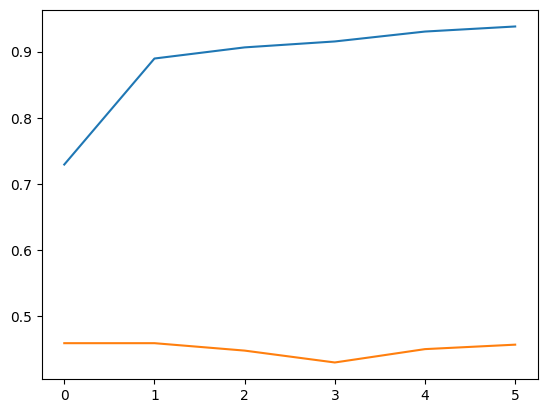

In [37]:
plt.plot(history['train_acc'], label='accuracy')
plt.plot(history['val_acc'], label='val_accuracy')

In [73]:
predict_text = "Ancient Law and Society"
tokens = tokenizer(predict_text)
sequence = torch.tensor([vocab[token] for token in tokens]).unsqueeze(0)
with torch.no_grad():
    model.eval()
    output = model(sequence)[0]
    probabilities = torch.nn.functional.softmax(output)

    top_probs, top_indices = torch.topk(probabilities, k=5)
    top_probs = top_probs.squeeze().tolist()
    top_indices = top_indices.squeeze().tolist()

    print(f"Top 5 predicted departments for '{predict_text}':")
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        department = label_encoder.inverse_transform([idx])[0]
        print(f"{i+1}. {department}: {prob*100:.2f}%")

Top 5 predicted departments for 'Ancient Law and Society':
1. Classics: 58.46%
2. Archaeology: 9.90%
3. Religious Studies: 5.77%
4. Judaic Studies: 4.71%
5. Anthropology: 4.65%


/var/folders/8v/z7_lynrn24bbpwy6p36j3cwc0000gn/T/ipykernel_56971/803345186.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(output)
